In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV files
pre_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_pre_may_2017.csv')
post_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_post_may_2017.csv')

In [204]:
price_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_av_price_cigarettes_king_size_filter/Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv'

price = pd.read_csv(price_url)

In [205]:
vat_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/IFS%20historic%20VAT%20-%20Sheet1.csv'
vat = pd.read_csv(vat_url)

In [206]:
# Drop the 'Start Year' column as it's no longer needed
vat = vat.drop(columns=['Reducedb', 'Highera', 'Registration threshold']).reset_index()

In [207]:
# Extract the first year from the 'Year' column and convert to integer
vat['Start Year'] = vat['Year'].str.split('-').str[0].astype(int)
vat = vat[vat['Start Year'] >= 2000].reset_index()
vat = vat.drop(columns=['index', 'level_0'])

In [208]:

# Strip the last character from the 'standard' column at index 8 and 9
for index in [8, 9]:
    if vat.at[index, 'Standard'].endswith('f'):
        vat.at[index, 'Standard'] = vat.at[index, 'Standard'][:-1]

In [209]:
price['Price in £'] = price['Pence'] / 100
price = price[price['year'] >= 2000].reset_index()
price = price.drop(columns=['index'])

In [210]:
# Ensure 'Date' columns are datetime types
# Ensure 'Date of change' columns are datetime types without converting parsing errors to NaT
pre_may_2017_df['Date of change'] = pd.to_datetime(pre_may_2017_df['Date of change'], format='%Y-%m-%d')
post_may_2017_df['Date of change'] = pd.to_datetime(post_may_2017_df['Date of change'], format='%Y-%m-%d')

In [211]:
#Drop columns not needed
pre_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg'], inplace=True)
post_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg', 'TfH £ per kg'], inplace=True)

In [212]:
combined_df = pd.concat([pre_may_2017_df, post_may_2017_df]).sort_values(by='Date of change').reset_index(drop=True)

In [213]:

# Convert 'Date of change' to datetime format
combined_df['Date of change'] = pd.to_datetime(combined_df['Date of change'])

# Drop rows where the year is earlier than 2000
combined_df = combined_df[combined_df['Date of change'].dt.year >= 2000].reset_index()

In [215]:
# Extract year from 'Date of change' column in combined_df
combined_df['Year'] = combined_df['Date of change'].dt.year

# Merge price with combined_df based on year and align prices
combined_df = combined_df.merge(price, how='left', left_on='Year', right_on='year')

# Create 'Retail price of King size pack in £' column
combined_df['Retail price of King size pack in £'] = np.where(combined_df['Year'] == combined_df['year'], combined_df['Price in £'], np.nan)

combined_df.drop(columns=['year', 'Price in £', 'Pence', 'Year'], inplace=True)

In [216]:
# Extracting year from 'Date of change' in combined_df
combined_df['When'] = combined_df['Date of change'].dt.year

# Extracting 'Start Year' from 'Year' in VAT
vat['Start Year'] = vat['Year'].str.split('-').str[0].astype(int)


# Rename the 'Year' column in VAT to avoid conflicts
vat.rename(columns={'Year': 'VAT Year'}, inplace=True)

# Merging combined_df and VAT
combined_df = combined_df.merge(vat, how='left', left_on='When', right_on='Start Year')

# Creating 'VAT' column based on condition
combined_df['VAT'] = np.where(combined_df['When'] == combined_df['Start Year'], combined_df['Standard'], np.nan)

# Dropping unnecessary columns
combined_df.drop(columns=['When', 'Start Year', 'Standard', 'VAT Year', 'index' ], inplace=True)


In [217]:
def calculate_duty(date, cigarettes_per_pack):

    # Get the retail price for the given date
    retail_price = combined_df.loc[combined_df['Date of change'] == date, 'Retail price of King size pack in £'].iloc[0]
    # Check if the retail price is NaN
    if pd.isna(retail_price):
        return np.nan
    if date < pd.to_datetime('2017-05-20'):
        # Historical duty pre-May 2017
        if not pre_may_2017_df.empty:
            pre_may_rows = pre_may_2017_df[pre_may_2017_df['Date of change'] <= date]
            if not pre_may_rows.empty:
                row = pre_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack
                total_duty = percentage_duty + specific_duty_per_pack 
            else:
                total_duty = 0  # No historical data available
        else:
            total_duty = 0  # No historical data available
    else:
        # Duty post-May 2017
        if not post_may_2017_df.empty:
            post_may_rows = post_may_2017_df[post_may_2017_df['Date of change'] <= date]
            if not post_may_rows.empty:
                row = post_may_rows.iloc[-1]
                specific_duty_per_pack = (row['Specific £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted duty for a pack
                minimum_excise_tax_per_pack = (row['Minimum excise tax £ per 1000 sticks'] / 1000) * cigarettes_per_pack  # Adjusted column name here
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')
                # Calculate the percentage duty for a pack
                percentage_duty = (ad_valorem_percentage / 100) * retail_price
                # Total duty for a pack using specific duty plus percentage
                total_duty_1 = percentage_duty + specific_duty_per_pack             
                # Total duty for a pack using minimum excise tax
                total_duty_2 = minimum_excise_tax_per_pack
                # Take the higher of the two total duties
                if total_duty_1 > total_duty_2:
                    total_duty = round(total_duty_1, 2)
                else:
                    total_duty = round(total_duty_2, 2)
            else:
                total_duty = 0  # No post-May 2017 data available
        else:
            total_duty = 0  # No post-May 2017 data available
    return round(total_duty,2)

In [218]:
combined_df['Duty'] = combined_df['Date of change'].apply(lambda x: calculate_duty(x, 20))

In [219]:
combined_df['VAT Amount'] = round((combined_df['Retail price of King size pack in £'] / (1 + (pd.to_numeric(combined_df['VAT'], errors='coerce')/100))) * (pd.to_numeric(combined_df['VAT'], errors='coerce')/100),2)

In [220]:
combined_df['Total tax'] = round(combined_df['Duty'] + combined_df['VAT Amount'],2)

In [221]:
combined_df['Percentage tax'] = round(((combined_df['Total tax'] / combined_df['Retail price of King size pack in £']) * 100))

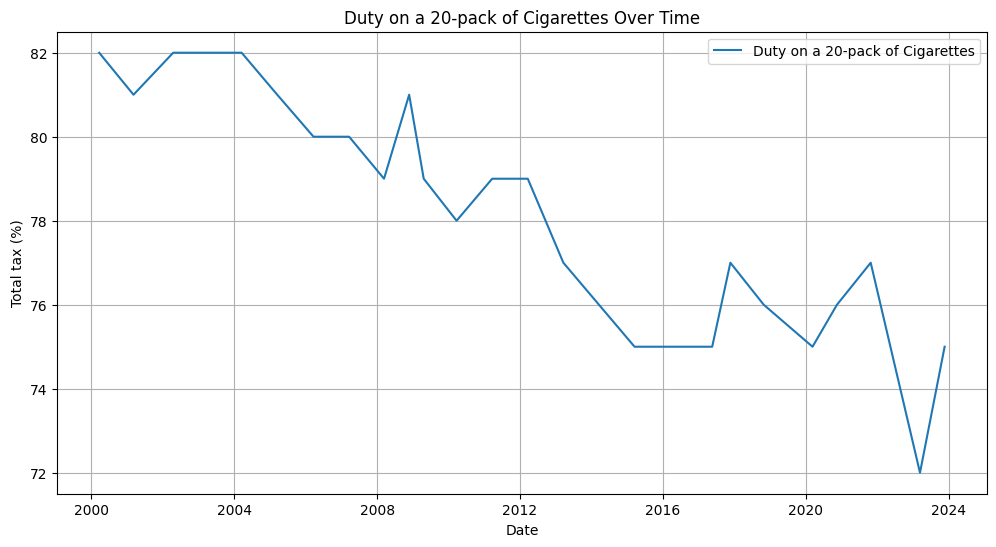

In [222]:
# Plotting the duty over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date of change'], combined_df['Percentage tax'], label='Duty on a 20-pack of Cigarettes', color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Total tax (%)')
plt.title('Duty on a 20-pack of Cigarettes Over Time')
plt.legend()
plt.grid(True)
plt.show()

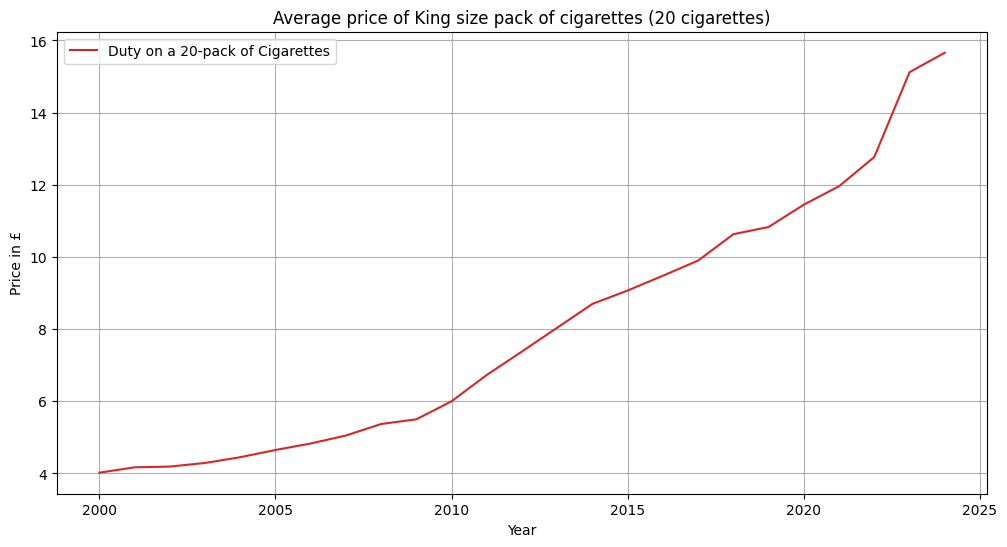

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(price['year'], price['Price in £'], label='Duty on a 20-pack of Cigarettes', color='tab:red')
plt.xlabel('Year')
plt.ylabel('Price in £')
plt.title('Average price of King size pack of cigarettes (20 cigarettes)')
plt.legend()
plt.grid(True)
plt.show()